## 1.0. Simulating the Brownian Motion

Monte Carlo simulation has been applicable to many different areas. Finance is no exception. Due to the complexity and the uncertainty in the financial markets, simulation technique is a necessity to forecast future price movement of an underlying asset. Given some pre-specified conditions, simulation gives us an insights about how price of an asset moves.

In this part, we will simulate a stock price, which is assumed to have log-normal distribution and random. Due to the randomness, stock prices model cannot be obtained by `ordinary differential equations` but by `stochastic differential equations`

We can think of a basic stock price simulation as an AR(1) process, which is given by:

$$S_t=\mu+S_{t-1}+\epsilon_t$$

where $S_t$ and $S_{t-1}$ are the stock price at t and t-1, respectively. $\epsilon_t$ error term at time t and finally $\mu$ is known as drift term. If step size is taken as $\sqrt{t}$ and if $t\rightarrow$ 0, then we have a Brownian Motion, which is defined as constantly small and random fluctuations. In finance, many models are based on the stochastic differential equation and its main component is Brownian motion. For those who interested in this concept might find this [link](https://en.wikipedia.org/wiki/Brownian_motion) helpful.

It is useful to have some simple specific examples to which we can refer. In fact, rather than simply specifying the distribution at a fixed time, we introduce a model for the dynamics of the stock price. The Black-Scholes model describes the evolution of the stock price through the stochastic differential equation.

$$\frac{dS(t)}{S(t)}=rdt+\sigma dW(t) \text{ eq.3}$$

where W a standard Brownian motion.  This equation may be interpreted as modeling the percentage changes dS/S in the stock price as the increments of a Brownian motion. The parameter σ is the volatility of the stock price and the coefficient on dt in eq.3 is the mean rate of return. 

Geometric Brownian Motion is one of the mainly used model to simulate stock prices and the solution of the stochastic differential eq.3 is:

$$S_t=S_{t-1}e^{(r-\sigma^2/2)t+\sigma W_t}$$

Different from above-given equation, $\sigma$ represents daily volatility, t is the time interval, and W is the brownian motion assumed to have normal distribution. The following simulation is done to show how we obtain Brownian Motion, which is main and noise component of stock price simulation. The `cumsum` function is used when we want to compute the cumulative sum of array elements over a given axis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import binom
from numpy.random import randint
import yfinance as yf
import seaborn as sns; sns.set()

In [2]:
def brownian_motion(T, N):
    """
    T: total time
    N: The total number of steps
    W0: First Value of Brownian Motion
    dt: Time increment
    """
    W0 = 0
    dt = T/N
    increments = np.random.normal(0, 1*np.sqrt(dt), N)
    W = W0 + np.cumsum(increments)
    return W

In [3]:
T=1# maturity
N=10**3 # number of time steps
dt = T / float(N)# time increments
t=np.linspace(0.,N*dt,N)

In [4]:
W=brownian_motion(T, N)

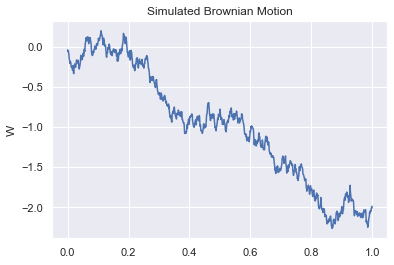

In [5]:
W=brownian_motion(T, N)
plt.plot(t, W)
plt.ylabel('W')
plt.title('Simulated Brownian Motion')
plt.show()

We just generate single brownian motion, feel free to generate many as we do below. As it is a random simulation, at each iteration, we will get a Brownian Motion with different path but with some characteristics.

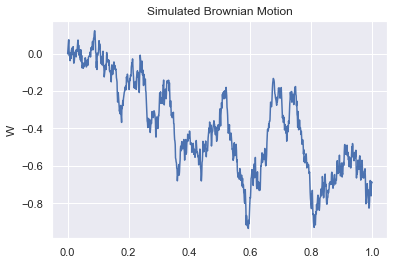

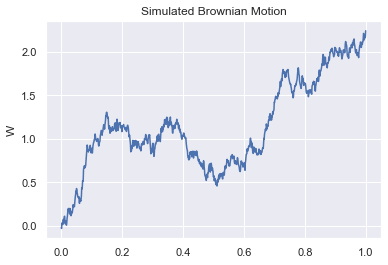

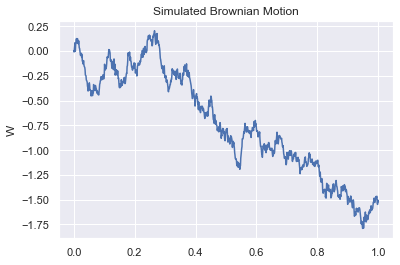

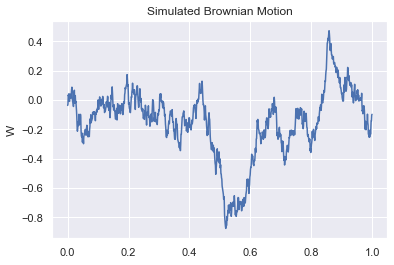

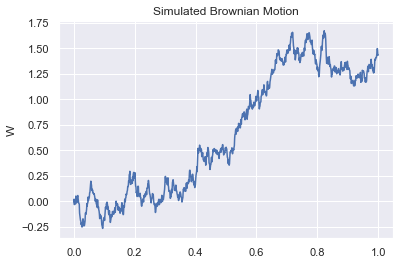

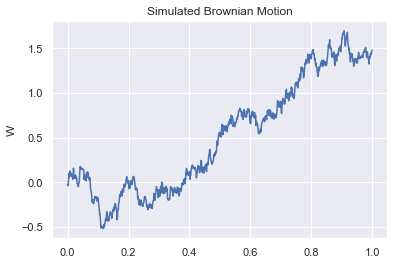

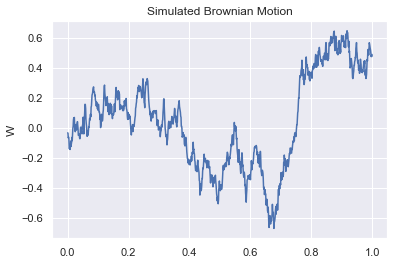

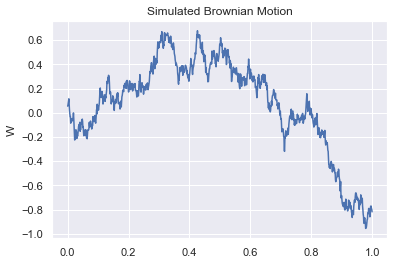

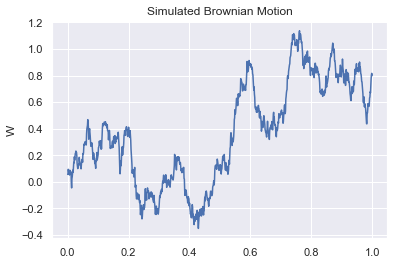

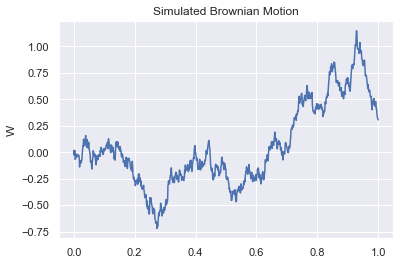

In [6]:
for i in range(10):
    W=brownian_motion(T, N)
    plt.plot(t, W)
    plt.ylabel('W')
    plt.title('Simulated Brownian Motion')
    plt.show()

## Option Pricing with Monte Carlo

In [7]:
from optionprice import Option
import numpy as np
from scipy.stats import norm
import datetime

In [8]:
S = 100
v = 0.2
r = 0.003 
K= 110

In [9]:
T = (datetime.date(2013,9,21) - datetime.date(2013,9,3)).days / 365.0

In [10]:
discount_factor = np.exp(-r * T)

In [11]:
def sim_asset_price(S,v,r,T):
    return S * np.exp((r - 0.5 * v**2) * T + v * np.sqrt(T) * np.random.normal(0,1.0))

In [12]:
def call_payoff(S_T, K):
    return max(S_T - K, 0.0)

In [13]:
simulations = 90000
payoffs = []
for i in range(simulations):
    S_T = sim_asset_price(S,v,r,T)
    payoffs.append(call_payoff(S_T, K))

In [14]:
call_price = discount_factor * (sum(payoffs) / float(simulations))
print('Call Price: {}'.format(call_price))

Call Price: 0.02707067433221223


In [15]:
call_option = Option(european=True,
                    kind='call',
                    s0=100,
                    k=110,
                    t=18,
                    sigma=0.2,
                    r=0.003,
                    dv=0)

In [16]:
call_price = call_option.getPrice(method='MC',iteration = 90000)
print('Call price is {}'.format(call_price))

Call price is 0.027457311130762333


In [17]:
def put_payoff(S_T, K):
    return max(K-S_T, 0.0)

In [18]:
simulations = 90000
payoffs = []
for i in range(simulations):
    S_T = sim_asset_price(S,v,r,T)
    payoffs.append(put_payoff(S_T, K))

In [19]:
put_price = discount_factor * (sum(payoffs) / float(simulations))
print('Put Price is {}'.format(put_price))

Put Price is 10.012908498730122


In [20]:
put_price = Option(european=True,
                    kind='put',
                    s0=100,
                    k=110,
                    t=18,
                    sigma=0.2,
                    r=0.003,
                    dv=0)

In [21]:
put_price = put_price.getPrice(method='MC',iteration = 90000)
print('Put price is {}'.format(put_price))

Put price is 10.042858854301125


## 1.1. Coffee price Simulation  via Monte Carlo 

Now, we are ready to simulate coffee price. To do that, we will use coffee price and starting from the last element , corresponding to `2014-10-07`, we start simulation:

In [22]:
def coffee_price_simulation():
    coffee_price=pd.read_csv('nce_spot_prices14-212.csv')
    coffee_price['Date'] = pd.to_datetime(coffee_price['Date'], format='%Y-%m-%d',errors='ignore')
    coffee_price=coffee_price.set_index('Date')
    annual_vol = (coffee_price/coffee_price.shift(1)-1)[1:].std()*np.sqrt(39)
    mu = coffee_price.pct_change().iloc[:-39].mean()
    sigma = coffee_price.pct_change().iloc[:-39].std()
    S0 = coffee_price.iloc[-1]
    T = 1.0
    N=1000
    delta_t = T/N
    iterations = 50
    time_steps = T/delta_t
    t=np.linspace(0.,N*delta_t,N+1)
    plt.figure(figsize=(15,10))
    for j in range(iterations):
        price_path = [S0]
        St = S0
        for i in range(int(time_steps)):
            St = St*np.exp((mu-0.5*sigma**2)*delta_t + sigma*np.sqrt(delta_t)*np.random.normal(0, 1))
            price_path.append(St)
        plt.plot(t,price_path)
    plt.ylabel('Simulated coffee Price')
    plt.xlabel('Time Steps')
    plt.show()

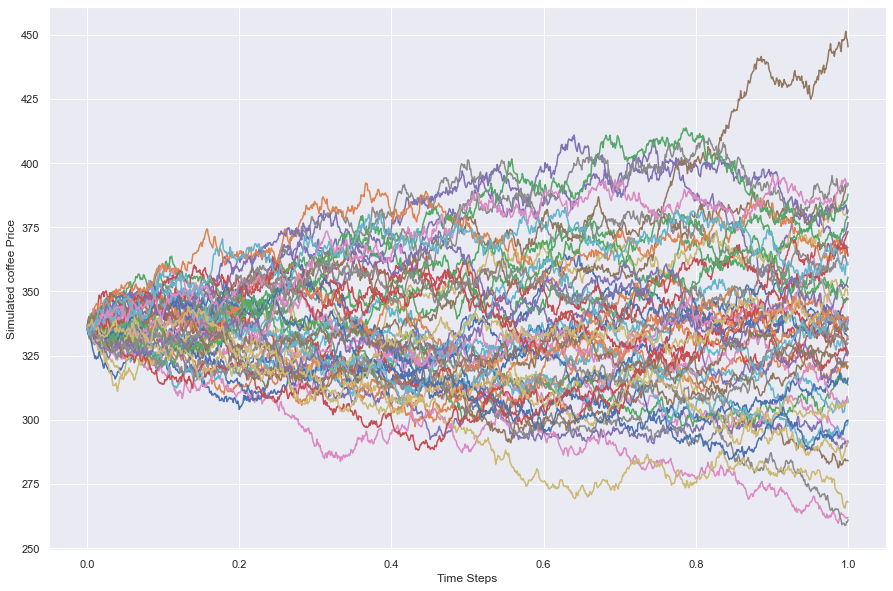

In [23]:
coffee_price_simulation()

**Advantages of Basic Monte Carlo Simulation**

1. Flexible and intuitive
2. Easy-to-apply 
3. Adjustable to the changing situation

**Disadvantages of Basic Monte Carlo Simulation**

1. Computational time: Dependent on the complexity of the problem the running time maybe long
2. Solutions are approximate and subject to number of iterations.

**Reference**

* Malvin H. Kalos, Paula A. Whitlock, Monte Carlo Methods, Wiley-VCH, 2008

# 3. Volatility Modeling and Its Application with Python

Due to the increased integrations, complex and deepening financial operations, financial market has high level of uncertainty, which should be understood and modeled to gain insight about what is going on in the market. Uncertainty comes in the form of volatility, which, in turn, amounts to information. To this end, determining the causes of volatility in financial markets and predicting these movements beforehand have become an indispensable condition of financial success in these markets.

Besides, volatility and risk go in tandem in financial markets. Increasing risk emanating from volatility poses a huge thread on the investment decisions. So, it is not adequate to know current volatility in the market, investors should have knowledge about the likely future path of volatility as well. Only after that, investor can properly gauge the market dynamics and risk level, which enables her to invest in a well-founded way.

Despite its theoretical appealing and intuitiveness, some of the main assumptions of financial modeling have been attacked by some researcher. As it is empirically shown, asset returns do not conform to the assumptions of random walk theorem such as constant variance and independence. Besides, linear models are not be able to capture the main characteristics of financial variables, which are:

* Leptokurtosis: By and large, financial variables show fat tail and excess peakedness, which is a deviation from normal distribution.
* Volatility Clustering: In financial markets, volatilities comove. That is to say, a high volatility is followed or another high volatility or vice versa.
* Leverage: Empirical studies suggests that there is an asymmetry in volatility meaning that volatility in high price drop can generate higher volatility than a price increase can.

In this nootbook, we will study some well-known volatility models using the coffee prices data set:
* `ARCH`, 
* `GARCH`, and 
* `EGARCH` 

Then, we will conduct prediction analyses based on them.

## 3.1. Volatility Prediction based on ARCH model 

In order to take into account all these deviations, i.e. leptokurtosis, volatility clustering, and leverage, `ARCH` (Autoregressive Conditional Heteroscedasticity) models, by Engle (1982) and Bollerslev (1986), has been proposed. Mathematically speaking, 

$$
\sigma^2_t=\alpha_0+\alpha_1u^2_{t-1}+\alpha_2u^2_{t-2}+\cdots...+\alpha_qu^2_{t-q}=\alpha_0+\sum_i^q\alpha_iu^2_{t-i}
$$

where $\alpha_0>0, \alpha_i>0, \text{ and } u_t=\sigma_tz_t$

The steps we need to estimate the ARCH model are:
* Fitting autoregressive model to obtain $u_i$. $r_t=\alpha_0+\alpha_1r_{t-1}+\cdots...+\alpha_pr_{t-q}+u_t$
* After having $u^2$, regress them on a constant $\alpha$ and q lagged values of error terms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [25]:
coffee_price=pd.read_csv('nce_spot_prices14-212.csv')
coffee_price['Date'] = pd.to_datetime(coffee_price['Date'], format='%Y-%m-%d',errors='ignore')
coffee_price=coffee_price.set_index('Date')

In [26]:
coffee_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2014-10-07 to 2021-07-27
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Avg Price  248 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [27]:
coffee_price.head()

,Avg Price
Date,
2014-10-07,244.79
2014-10-14,250.83
2014-10-22,224.83
2014-10-28,225.50
2014-11-05,226.03


In [28]:
coffee_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2014-10-07 to 2021-07-27
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Avg Price  248 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


Text(0.5, 0, 'Time')

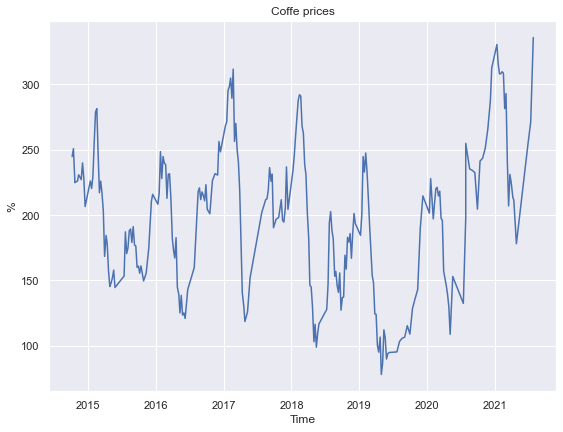

In [29]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.plot(coffee_price['Avg Price'])
#plt.xticks(rotation=360)
plt.ylabel('%')
plt.title('Coffe prices')
plt.xlabel('Time')

In [30]:
realized_vol=coffee_price['Avg Price'].rolling(3).std()

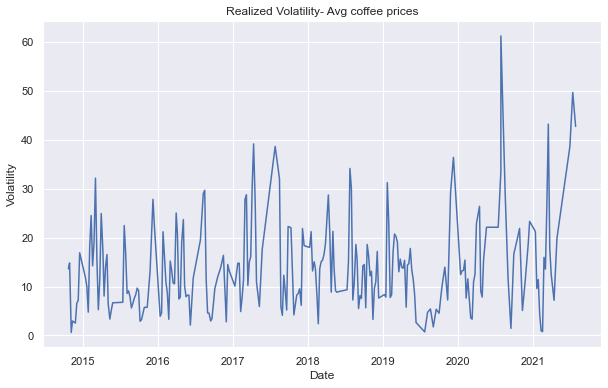

In [31]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- Avg coffee prices') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()

In [32]:
from arch import arch_model

In [33]:
results_arch=[]
for i in coffee_price.columns:
    results_arch.append(arch_model((coffee_price[i]),mean='Constant',vol='arch',dist='Normal').fit(disp='off'))

The result of the ARCH(1) model is given below, `omega` and `alpha` are constant term and slope coefficient, respectively. Based on this estimation, we conduct our prediction. In prediction, we employ these estimated coefficients:

In [34]:
results_arch

[                      Constant Mean - ARCH Model Results                      
 Dep. Variable:              Avg Price   R-squared:                       0.000
 Mean Model:             Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                       ARCH   Log-Likelihood:               -1273.81
 Distribution:                  Normal   AIC:                           2553.61
 Method:            Maximum Likelihood   BIC:                           2564.15
                                         No. Observations:                  248
 Date:                Fri, Dec 10 2021   Df Residuals:                      247
 Time:                        12:41:26   Df Model:                            1
                                  Mean Model                                 
                  coef    std err          t      P>|t|      95.0% Conf. Int.
 ----------------------------------------------------------------------------
 mu           214.7227      3.157     68.020  

## 3.2. Volatility Prediction based on GARCH model 

Bollerslev (1986) and Taylor (2008) improved ARCH model by adding lagged conditional variance into the equation and it is referred to as `GARCH` (The Generalized Autoregressive Conditional Heteroscedasticity). The mathematical equation is similar to ARCH except for one term, which is past values of conditional volatility $\sigma^2$:

$$
\sigma^2_t=\omega+\beta\sigma^2_{t-1}+\alpha u^2_{t-1}
$$

where $\omega$, $\beta$, and $\alpha$ are parameters and have restrictions: $\omega$ $>$ 0, $\beta$ $\geq$ 0, and $\alpha$ $\geq$ 0. 

In [35]:
results_garch=[]
for i in coffee_price.columns:
    results_garch.append(arch_model((coffee_price[i]),mean='Constant',vol='garch',dist='Normal').fit(disp='off'))

Different from ARCH model, we have one more variable $\beta$ attached to lagged values of conditional variance. GARCH(1,1) model result is exhibited below:

In [36]:
results_garch

[                     Constant Mean - GARCH Model Results                      
 Dep. Variable:              Avg Price   R-squared:                       0.000
 Mean Model:             Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                      GARCH   Log-Likelihood:               -1273.81
 Distribution:                  Normal   AIC:                           2555.61
 Method:            Maximum Likelihood   BIC:                           2569.66
                                         No. Observations:                  248
 Date:                Fri, Dec 10 2021   Df Residuals:                      247
 Time:                        12:41:26   Df Model:                            1
                                  Mean Model                                 
                  coef    std err          t      P>|t|      95.0% Conf. Int.
 ----------------------------------------------------------------------------
 mu           214.7231      3.382     63.483  

## 3.3. Volatility Prediction based on EGARCH model 

In the outset of this lesson, we talk about asymmetry in volatility. Not every events lead to same volatility so that it is a necessity to capture this volatility asymmetry. `EGARCH`(The exponential generalized autoregressive conditional heteroskedastic) is one of the models that can successfully consider this asymmetry. The equation is rather complex compared to ARCH and GARCH but we do not need to worry about that. The equation of EGARCH is 

$$\text{log}(h_t)=\omega + \sum^p_{j=1}\beta_j \text{log}(h_{t-j})+ \sum^q_{i=1}\alpha_i\frac{|u_{i-1}|}{\sqrt{h_{t-i}}}+\sum^q_{i=1}\gamma_i\frac{u_{t-i}}{\sqrt{h_{t-i}}}
$$

$\omega$ grasps the asymmetric shocks of volatility and $\alpha$ capture the volatility clustering. Thus, asymmetric shocks of volatility and volatility of clustering are captured by the EGARCH model.

In [37]:
results_egarch=[]
for i in coffee_price.columns:
    results_egarch.append(arch_model((coffee_price[i]),mean='Constant',vol='egarch',dist='Normal').fit(disp='off'))

The result of EGARCH model is given below:

In [38]:
results_egarch

[                     Constant Mean - EGARCH Model Results                     
 Dep. Variable:              Avg Price   R-squared:                       0.000
 Mean Model:             Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                     EGARCH   Log-Likelihood:               -1279.41
 Distribution:                  Normal   AIC:                           2566.82
 Method:            Maximum Likelihood   BIC:                           2580.87
                                         No. Observations:                  248
 Date:                Fri, Dec 10 2021   Df Residuals:                      247
 Time:                        12:41:27   Df Model:                            1
                                  Mean Model                                 
                  coef    std err          t      P>|t|      95.0% Conf. Int.
 ----------------------------------------------------------------------------
 mu           214.5746      0.279    769.913  

# Conclusion

Modeling volatility is of considerable importance in today's highly integrated, turbulent, and sophisticated financial markets. This study provides looks at the main volatility models. However, as you can imagine, there are many other models that tries to improve the deficiencies of the exiting model and capture the real-world situation in a better fashion.

# References

* [Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. Journal of econometrics, 31(3), 307-327.](http://www.u.arizona.edu/~rlo/readings/278762.pdf)
* [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the Econometric Society, 987-1007.](http://www.econ.uiuc.edu/~econ536/Papers/engle82.pdf)